# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

$$ \frac{d^2 u(x)}{d^2 x}  = f(x)\quad \forall x \in (0, \pi)$$

con $u(0) = u(\pi) = 0$.


## Aproximación de la función

En este caso tenemos una aproximación

$$u_\theta(x) \approx \operatorname{NN}(x; \theta)\, ,$$

dondee $\operatorname{NN}$ es una red neuronal con parámetros
entrenables $\theta$.

El residual para este problema estaría dado por

$$R(x) = \frac{d^2 u_\theta(x)}{d^2 x}  - f(x) \, .$$

Por el caracter no linealidad respecto a los parámetros
$\theta$ de las redes neuronales evaluar el residual
en una serie de puntos $x_i$  y forzarlo a ser cero
en estos puntos, llevaría a un sistema
no lineal de ecuaciones

$$R(x_i) = 0 \quad \forall x_i\, .$$

## Función de pérdida

Una alternativa a resolver el sistema de ecuaciones anteriormente
planteado es minimizar

$$\min_\theta \frac{1}{N}\sum_{i}^N |R(x_i)|^2 \, .$$

Que sería exactamente 0 si cada uno de los residuales es igual a 0.

A este problema le harían falta las condiciones de frontera. Para
esto se propone una función objetivo que las incluya

$$\min_\theta \frac{1}{N}\sum_{i}^N R(x_i)^2  + \lambda_1 u_\theta(0)^2
+ \lambda_2 u_\theta(\pi)^2\, .$$

## Ejemplo computacional

In [1]:
# Import required packages
using Lux                  # Neural network definition and training
using LuxCUDA
using TaylorDiff           # Automatic differentiation
using Optimization         # Optimization problem solving
using Optimisers           # Optimizers such as Adam
using Random               # Random number generation
using Plots                # Plotting utilities
using Zygote               # Automatic differentiation
using ComponentArrays      # Array utilities for handling model parameters
using Printf               # Advanced formatted printing
using LinearAlgebra        # Linear algebra operations
using Statistics           # Statistical operations
using OptimizationOptimisers  # Optimization extensions for Optimisers
using OptimizationOptimJL     # Optimization extensions for LBFGS

In [1]:
using Lux, Optimization, OptimizationOptimisers, OptimizationOptimJL, OrdinaryDiffEqTsit5,
      SciMLSensitivity, Random, MLUtils, CairoMakie, ComponentArrays, Printf

In [4]:
using CUDA
using cuDNN

In [5]:
# Initial program setup
# Seeding for reproducibility
rng = Random.default_rng()
Random.seed!(rng, 0)

# Device configuration (CPU/GPU)
const DEVICE_CPU = cpu_device()  #  device cpu_device() gpu_device() 
const DEVICE_GPU = gpu_device()  #  device cpu_device() gpu_device()

ErrorException: invalid redefinition of constant Main.DEVICE_GPU

In [4]:
# Data preparation
# Input range and target output
INPUT_RANGE = range(0, pi, length=1000)
input_data = Float64.(reshape(collect(INPUT_RANGE), 1, :))  |> DEVICE_GPU # Input data
f_rhs(x) = reshape(Float64.(-4*sin.(2*x)), 1, :)  # f_rhs
data = input_data |> DEVICE_GPU  # Move data to the selected device 

1×1000 Matrix{Float64}:
 0.0  0.00314474  0.00628947  …  3.13216  3.1353  3.13845  3.14159

In [5]:
# Neural network definition
# Architecture: Network with multiple dense layers and tanh activation ; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros64
const HIDDEN_UNITS = 10
model = Chain(
    Dense(1 => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh;  init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => 1; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32)
)

# Model initialization
params, states = Lux.setup(rng, model)  # Initial parameters and states
params = ComponentArray(params) |> DEVICE_GPU  # Move parameters to the device
states = states |> DEVICE_GPU  # Move states to the device
smodel = StatefulLuxLayer{true}(model, params, states)  # Stateful model layer

StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(1 => 10, tanh),  # 20 parameters
        layer_2 = Dense(10 => 10, tanh),  # 110 parameters
        layer_3 = Dense(10 => 10, tanh),  # 110 parameters
        layer_4 = Dense(10 => 1),       # 11 parameters
    ),
)         # Total: 251 parameters,
          #        plus 0 states.

In [12]:
# Definir el valor de ε1
εmachine = eps(Float32)
ε2 = εmachine^(1/4)

function loss_adjoint(params, (input_data))
    # Predicción de la red neuronal
    f(input_data) = smodel(input_data, params)

    # Calcular la derivada numérica usando diferencias finitas centradas
    ddu(input_data)=Float32.((f(input_data .+ ε2) .- 2f0 .* f(input_data) .+ f(input_data .- ε2)) / (ε2^2))

    # Ressiduo de la ecuación diferencial
    res_eq = ddu(input_data) - f_rhs(input_data) 
    loss_eq = mean((res_eq).^2)  
    loss_bc = Array(((f([0] |> DEVICE_GPU) .- (0)).^2) + ((f([Float32.(pi)] |> DEVICE_GPU) .- (0)).^2))[1] 
    total_loss = loss_eq + loss_bc
    return total_loss
end

# Callback function
# Monitors training progress
function callback(state, l)
    state.iter % 100 == 1 && @printf "Iteration: %5d, Loss: %.12e\n" state.iter l
    return l < 1e-8  # Stop if loss is sufficiently small
end

callback (generic function with 1 method)

In [14]:
data = (input_data)  # Data tuple

# Definir el problema de optimización
opt_func = OptimizationFunction(loss_adjoint, Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, params, data)
iters = 1_01  # Número máximo de iteraciones

101

In [15]:
# Train using the Adam optimizer
res_adam = solve(opt_prob, Optimisers.Adam(1e-3), callback=callback, maxiters=iters)

Iteration:     1, Loss: 7.941356182098e+00
Iteration:   101, Loss: 4.687878131866e+00


retcode: Default
u: ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = Float32[0.056712613; -0.22742094; … ; -0.32872373; 0.15970543;;], bias = Float32[-0.00843644, -0.07975837, -0.010569268, 0.1296979, 0.043093104, -0.10054696, 0.12343621, 0.07716102, 0.118493326, -0.09760053]), layer_2 = (weight = Float32[0.31987324 0.14515014 … 0.30366907 0.25661707; 0.22318526 0.012982032 … -0.19867021 -0.39807785; … ; -0.16660908 0.3933242 … -0.5296331 0.19200855; 0.20854335 0.14054386 … 0.18982954 0.32030502], bias = Float32[-0.07607042, 0.05743798, 0.05307217, 0.00336664

In [23]:
# Redefine the optimization problem with updated parameters
opt_prob = OptimizationProblem(opt_func, res_adam.u, data)

# Further training using the LBFGS optimizer
res_lbfgs = solve(opt_prob, OptimizationOptimJL.LBFGS(); callback, maxiters=iters)

Iteration:     1, Loss: 3.892953157425e+00


retcode: Failure
u: ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = Float32[-0.6963465; -0.3350487; … ; -1.350794; 0.23168063;;], bias = Float32[0.579174, -0.53890723, -0.9896039, 1.3927808, -0.61911386, -0.22107121, 1.2838202, -0.3928507, 0.6442622, -0.13382705]), layer_2 = (weight = Float32[0.27790704 0.28024518 … 0.44253442 0.18269835; 0.16072619 0.06469151 … -0.13899569 -0.45018739; … ; -0.08841362 0.264343 … -0.8902786 0.25291002; 0.24036266 0.042251498 … 0.07364487 0.44674733], bias = Float32[-0.2258189, 0.037116975, -0.6961667, -0.19781263, -0.0991288

In [236]:
# Make predictions with the optimized model
pred = smodel(input_data, res_adam.u)

1×2000 Matrix{Float64}:
 1.67803e-7  0.00315458  0.0063087  0.0094625  …  -0.00466546  -0.00154371

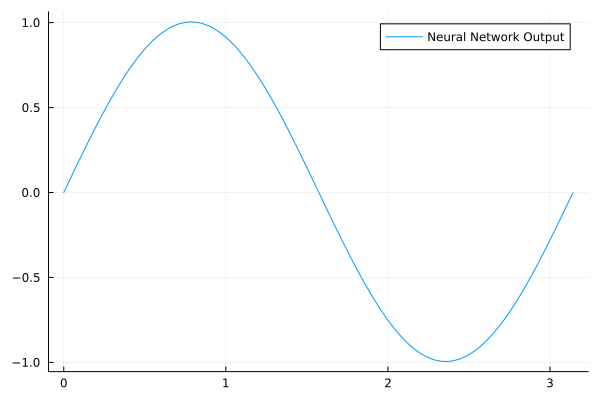

In [237]:
plot(Array(input_data)', Array(pred)', label="Neural Network Output")